<a href="https://colab.research.google.com/github/ziatdinovmax/atomai/blob/master/examples/notebooks/atomai_deep_ensembles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep ensembles for atom finding

Prepared by Maxim Ziatdinov (March 2020)

This notebook demonstrates an implementation of deep ensembles for atom detection with uncertainty quantification. 

(It is a good idea to mount Google Drive to the notebook's runtime for saving/loading models and data)

Check cloud GPU:

In [0]:
!nvidia-smi

Wed Apr 29 23:43:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

Install AtomAI:

In [0]:
pip install atomai

Import modules:

In [0]:
import h5py
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt

import atomai as aoi
import torch
torch.manual_seed(1) ;

Download training set. This training set is made from synthetic images of cubic atomic lattices where atoms are simulated as 2d Gaussians.

In [0]:
!gdown https://drive.google.com/uc?id=1nLLOfBehRhiWkZzyzuAmMqrFA2nRmn69 -O 'training_data.hdf5'
dataset = h5py.File('training_data.hdf5', 'r')
images_all = dataset['X_train'][()]
labels_all = dataset['y_train'][()]
images_test_all = dataset['X_test'][()]
labels_test_all = dataset['y_test'][()]
print(images_all.shape, labels_all.shape)

Define basic specs of neural nets that we will use throughout this notebook:

In [0]:
model_type = 'dilnet' # 'dilnet' has only max-pool operation which can lead to higher accuracy
layers = [2, 4, 4, 2] # number of layers in each dilnet block (see atomai.models documentation for details)
batchnorm = False # recommended setting is 'True' when using experimental data for training
dropouts = True # recommended setting is 'True' when using synthetic data for training
nb_filters = 32 # number of conv filters in 1st block (doubles in the consecutive blocks)
upsampling_method = 'nearest' # use 'nearest' instread of 'bilinear' for full reproducibility when running on gpu
criterion = 'ce' # using a numerically stable off-the-shelf PyTorch cross entropy loss

## Single training trajectory

We start by training two models from scratch and confirming that their final states are identical (i.e. they have identical values of weights and biases in each layer).

In [0]:
# first model
print('Training first model:')
netr1 = aoi.atomnet.trainer(
    images_all, labels_all, # training data
    images_test_all, labels_test_all, # test data
    model_type=model_type, nb_filters=nb_filters, # model specs
    use_batchnorm=batchnorm, use_dropouts=dropouts, # model specs
    upsampling=upsampling_method, loss=criterion, # model specs
    training_cycles=200, plot_training_history=False) # training epochs
# Train a baseline model
trained_model1 = netr1.run()

# second model
print('\nTraining second model:')
netr2 = aoi.atomnet.trainer(
    images_all, labels_all, # training data
    images_test_all, labels_test_all, # test data
    model_type=model_type, nb_filters=nb_filters, # model specs
    use_batchnorm=batchnorm, use_dropouts=dropouts, # model specs
    upsampling=upsampling_method, loss=criterion, # model specs
    training_cycles=200, plot_training_history=False) # training epcohs
# Train a baseline model
trained_model2 = netr2.run()

Training first model:
Epoch 1 ... Training loss: 0.6484 ... Test loss: 0.6494 ... GPU memory usage: 5987/16280
Epoch 100 ... Training loss: 0.4266 ... Test loss: 0.3566 ... GPU memory usage: 6387/16280
Epoch 200 ... Training loss: 0.2428 ... Test loss: 0.3147 ... GPU memory usage: 6387/16280
Model (final state) evaluation loss: 0.3011

Training second model:
Epoch 1 ... Training loss: 0.6484 ... Test loss: 0.6494 ... GPU memory usage: 5989/16280
Epoch 100 ... Training loss: 0.4266 ... Test loss: 0.3566 ... GPU memory usage: 6389/16280
Epoch 200 ... Training loss: 0.2428 ... Test loss: 0.3147 ... GPU memory usage: 6389/16280
Model (final state) evaluation loss: 0.3011


Let's assert that the parameters in two models are equal up to desired tolerance (1e-7 in this case):

(the cell below will return an AssertionError if this is not true)

In [0]:
from numpy.testing import assert_allclose

for p1, p2 in zip(trained_model1.parameters(), trained_model2.parameters()):
    assert_allclose(p1.detach().cpu().numpy(), p2.detach().cpu().numpy())

## Multiple training trajectories (ensemble training)

The general idea is to train a single model until loss starts to converge and then use it as a baseline for training an ensemble of models with different training trajectories. For each model in the ensemble, we feed batches of training images in a different order thus creating a unique training trajectory. You will see that, unlike in the example above, we end up with having a different validation loss every time (notice that ensemble models with close values of validation loss may produce rather different predictions on the new data, see e.g. https://arxiv.org/abs/1912.02757).

In [0]:
# Ititiate baseline model
netr = aoi.atomnet.trainer(
    images_all, labels_all, # training data
    images_test_all, labels_test_all, # test data
    model_type=model_type, nb_filters=nb_filters, # model specs
    use_batchnorm=batchnorm, use_dropouts=dropouts, # model specs
    upsampling=upsampling_method, loss=criterion, # model specs
    training_cycles=900, plot_training_history=False) # training epochs
# Train baseline model
print('Training baseline model:')
trained_model = netr.run()
# Save it to Google Drive
torch.save(
    trained_model.state_dict(), 
    '/content/drive/Shared drives/uqdl/ensemble_training/NiO_LSMO-baseline.pt')

# Train ensemble of models starting each time from baseline weights
initial_model_state_dict = trained_model.state_dict()
ensemble = {}
print('Training ensemble models:')
for i in range(30): # 30 runs seem to be sufficient
    print('Ensemble model', i+1)
    # initialize a new model
    netr_i = aoi.atomnet.trainer(
        images_all, labels_all, # training data
        images_test_all, labels_test_all, # test data
        model_type=model_type, nb_filters=nb_filters, # model specs
        use_batchnorm=batchnorm, use_dropouts=dropouts, # model specs
        upsampling=upsampling_method, loss=criterion, # model specs
        batch_seed=i, # batch_seed sets training trajectory
        training_cycles=100, # training epochs
        savename='NiO_LSMO_{}'.format(i), # save name for each model
        print_loss=10, plot_training_history=False) # print/plot settings
    # update initial weights with baseline weights
    netr_i.net.load_state_dict(initial_model_state_dict)
    # train a model
    trained_model_i = netr_i.run()
    # store the trained weights
    ensemble[i] = trained_model_i.state_dict() 
# save ensemble to Google Drive
torch.save(
    ensemble,
    '/content/drive/Shared drives/uqdl/ensemble_training/NiO_LSMO-ensemble.tar')
# Calculate and save averaged weights to Google Drive
ensemble_state_dict = aoi.utils.average_weights(ensemble)
torch.save(
    ensemble_state_dict, 
    '/content/drive/Shared drives/uqdl/ensemble_training/NiO_LSMO-ensemble-aver.pt')

Training baseline model:
Epoch 1 ... Training loss: 0.6484 ... Test loss: 0.6463 ... GPU memory usage: 5991/16280
Epoch 100 ... Training loss: 0.4266 ... Test loss: 0.377 ... GPU memory usage: 6391/16280
Epoch 200 ... Training loss: 0.2428 ... Test loss: 0.2396 ... GPU memory usage: 6391/16280
Epoch 300 ... Training loss: 0.1965 ... Test loss: 0.2214 ... GPU memory usage: 6391/16280
Epoch 400 ... Training loss: 0.3402 ... Test loss: 0.2126 ... GPU memory usage: 6391/16280
Epoch 500 ... Training loss: 0.2439 ... Test loss: 0.2487 ... GPU memory usage: 6391/16280
Epoch 600 ... Training loss: 0.2333 ... Test loss: 0.202 ... GPU memory usage: 6391/16280
Epoch 700 ... Training loss: 0.1963 ... Test loss: 0.1608 ... GPU memory usage: 6391/16280
Epoch 800 ... Training loss: 0.1712 ... Test loss: 0.211 ... GPU memory usage: 6391/16280
Epoch 900 ... Training loss: 0.1631 ... Test loss: 0.1568 ... GPU memory usage: 6391/16280
Model (final state) evaluation loss: 0.1925
Training ensemble models:


## Ensemble predictions

Load back the ensemble and saved averaged weights:

In [0]:
ensemble_state_dict = torch.load('/content/drive/Shared drives/uqdl/ensemble_training/NiO_LSMO-ensemble-aver-1.pt')
ensemble = torch.load('/content/drive/Shared drives/uqdl/ensemble_training/NiO_LSMO-ensemble-1.tar')

Load experimental data:

(remember that the models were trained on simulated data of a generic cubic lattice)

In [0]:
expdata = np.load('/content/drive/My Drive/Data/NiO_LSMO2.npy') # will be made available after the work is published

We next make a prediction for the experimental data with each model in the ensemble and with an averaged model. The experimental data is scanning transmission elelctron microscopy image of NiO-LSMO composite obtained by M. Chislom at ORNL.

In [0]:
# Compute coordinates with each model in the ensemble
coordinates_all = {}
nn_output_all = []
for i, w in ensemble.items():
    predictive_model = aoi.models.dilnet(
        nb_filters=nb_filters, batch_norm=batchnorm,
        use_dropout=dropouts, upsampling=upsampling_method, layers=layers)
    predictive_model.load_state_dict(w)
    predictive_model.eval()
    _, (nn_output, coordinates) = aoi.atomnet.predictor(
        expdata, predictive_model, 
        use_gpu=True, verbose=False).run()
    coordinates_all[i] = coordinates[0]
    nn_output_all.append(nn_output)
nn_output_all = np.concatenate(nn_output_all, axis=0)

/usr/local/lib/python3.6/dist-packages/atomai/atomnet.py:473: UserWarning: The output of predictor.run() has changed from 'nn_input, nn_output' to 'nn_input, (nn_output, coordinates)'. Example: 'nn_input, (nn_output, coordinates) = predictor(args).run()'
  warnings.warn(warn_msg, UserWarning)


Use the predicted coordinates to find clusters of predicted coordinates around each atom, and the associated mean and standard deviation (for each cluster/atom):

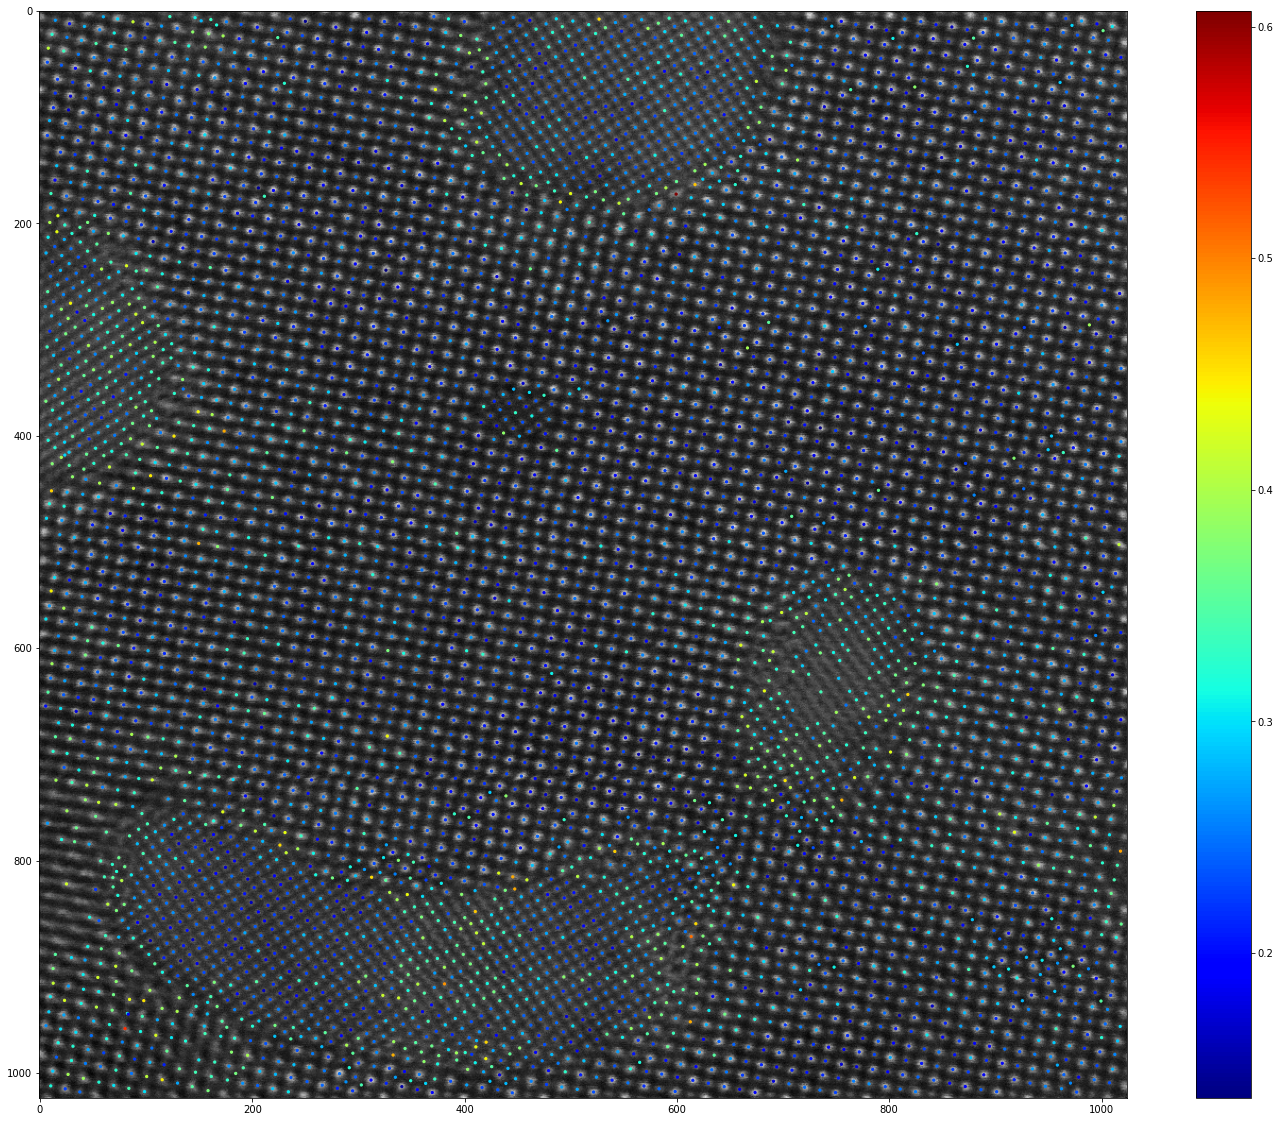

In [0]:
_, mean, std = aoi.atomstat.cluster_coord(coordinates_all, eps=0.5) # This is DBSCAN's epsilon

var_xy = np.sqrt(std[:, 1]**2 + std[:, 0]**2)

plt.figure(figsize=(25, 20))
plt.imshow(expdata, cmap='gray')
plt.scatter(mean[:, 1], 
            mean[:, 0], 
            c=var_xy, cmap='jet', s=5)
plt.colorbar()

Notice that embedded atomic islands and areas around them, which represent out-of-(training-)distribution features, are characterized by higher uncertainty. This tupe of information is exactly what we wanted/needed.

In addition, we can vizualize prediction with corresponding uncertainty in raw image pixels:

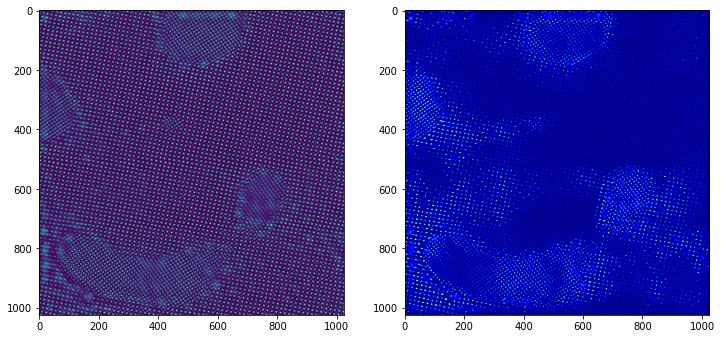

In [0]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(np.mean(nn_output_all[...,0], axis=0))
ax2.imshow(np.var(nn_output_all[...,0], axis=0), cmap='jet')
plt.show()